# Isolated Word Recognition with HMMs

<br><br>

## Imports <a name="im"></a>

In [1]:
import glob
import os
from collections import defaultdict

import IPython.display

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hmmlearn import hmm

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## 1: HMM warm-up <a name="1"></a>
<hr>

Consider a two word language _fish_ and _sleep_ with two possible part-of-speech tags: _noun_ and _verb_. Suppose in our training corpus, _fish_ appears 8 times as a noun and 5 times as a verb and _sleep_ appears 2 times as a noun and 5 times as a verb. The probability of a sentence starting with a noun is 0.8 and with a verb 0.2. The state transitions between noun and verb are shown in the picture below. Note that we have one extra state in the picture below, with the label 'End'. We have this state as an "accepting" state; we do not have any transitions from this state. We have added this state to make the transition probabilities work. Include a column for it in the transition matrix. But do not include it in the emission probabilities or when you run the Viterbi algorithm in the next exercise. 

<img src="img/HMM_POS_tagging.png" width="400" height="400">

(Credit: This idea of a two word language with the words _fish_ and _sleep_ is [Ralph Grishman](https://cs.nyu.edu/grishman/)'s idea.)

### 1.1 Define an HMM 

Define a hidden Markov model for part-of-speech tagging for this language. In particular, specify 

> 1. The states are ['noun', 'verb'].
2. The set of output alphabet is ['fish', 'sleep']
3. The inital state discrete probability distribution is given by $\pi= [0.8$  $0.2]$.
4. Transition probability matrix:
|     | Noun | Verb| End |
|:------:|:-:|:---:|:---:|
|**Noun**|0.1| 0.8 | 0.1 | 
|**Verb**|0.2| 0.1 | 0.7 |   
5. Emission probabilities
|        | Sleep | Fish|
|:------:|:-----:|:---:|
|**Noun**|  0.2  | 0.8 | 
|**Verb**|  0.5  | 0.5 |   




<br><br>

### 1.2 Find the best part-of-speech tag sequence  
Run the Viterbi algorithm to find the best part-of-speech sequence for the observed sequence:  

> fish fish sleep

In particular, calculate $\delta$ and $\psi$ at each state for each time step and then find the globally optimal sequence of tags for the above observed sequence. Show your work. 

### YOUR ANSWER HERE

#### Viterbi: Initialization (t=0)
- Initialize with $\delta_i(0) = \pi_i b_i(o_0)$ for all states
    - $\delta_{noun}(0) = \pi_{noun} b_{noun}(fish) = 0.8 \times 0.8 = 0.64$
    - $\delta_{verb}(0) = \pi_{verb} b_{verb}(fish) = 0.2 \times 0.5 = 0.1$
    
- Initialize with $\psi_i(0) = 0 $, for all states   
    - $\psi_{noun}(0) = 0, \psi_{verb}(0) = 0$

#### Viterbi: Induction (t=1)

$\delta$ and $\psi$ at state noun and T = 1
- $\delta_{noun}(1) = \max \begin{Bmatrix} \delta_{noun}(0) \times a_{noun-noun} \\ \delta_{verb}(0) \times a_{verb-noun}\end{Bmatrix}  \times b_{noun}(fish) = 
\max \begin{Bmatrix} 0.64 \times 0.1 \\ 0.1 \times 0.2\end{Bmatrix} \times 0.8 = 0.05125 $
- $\psi_{noun}(1)  = {noun}$

$\delta$ and $\psi$ at state verb and T = 1
- $\delta_{verb}(1) = \max \begin{Bmatrix} \delta_{verb}(0) \times a_{verb-verb} \\ \delta_{noun}(0) \times a_{noun-verb}\end{Bmatrix}  \times b_{verb}(fish) = \max \begin{Bmatrix} 0.64 \times 0.1 \\ 0.1 \times 0.8\end{Bmatrix} \times 0.5 = 0.04$
- $\psi_{verb}(1) = {noun}$

#### Viterbi: Induction (t=2)

$\delta$ and $\psi$ at state noun and T = 2
- $\delta_{noun}(2) = \max \begin{Bmatrix} \delta_{noun}(1) \times a_{noun-noun} \\ \delta_{verb}(1) \times a_{verb-noun}\end{Bmatrix}  \times b_{noun}(sleep) = 
\max \begin{Bmatrix} 0.05125 \times 0.1 \\ 0.04 \times 0.2\end{Bmatrix} \times 0.2 = 0.0016$
- $\psi_{noun}(2)  = {verb}$

$\delta$ and $\psi$ at state verb and T = 2
- $\delta_{verb}(2) = \max \begin{Bmatrix} \delta_{verb}(1) \times a_{verb-verb} \\ \delta_{noun}(1) \times a_{noun-verb}\end{Bmatrix}  \times b_{verb}(sleep) = \max \begin{Bmatrix} 0.04 \times 0.1 \\ 0.05125 \times 0.8\end{Bmatrix} \times 0.5 = 0.0205$
- $\psi_{verb}(2) = {noun}$

#### Conclusion
- Choose the best final state: $q_t^* = \arg \max\limits_i \delta_i(t)$
- Recursively choose the best previous state: $q_{t-1}^* = \psi_{q_t^*}(t)$
    - The most likely state sequence for the observation sequence fish-fish-sleep is noun-noun-noun.
- The probability of the state sequence is the probability of $q_t^*$ where sleep is a noun is $P(fish-fish-sleep) = 0.0205$  
    - The probability of the state sequence is the probability of $q_t^*$ where sleep is a verb is $P(fish-fish-sleep) = 0.0016$  

<br><br><br><br>

## 2: Isolated word recognition using HMMs <a name="2"></a>
<hr>

Hidden Markov Models (HMMs) provide a probabilistic framework for modeling sequences. Many modern statistical speech recognition systems are HMM-based systems. In fact, before deep neural networks, they used to be the state-of-the-art models in speech recognition. In this exercise, we will get a little taste of automatic speech recognition (ASR) using HMMs. In particular, the task of converting spoken words from a limited vocabulary into their corresponding text format. 

### Automatic speech recognition (ASR): quick introduction 

Before we look into the details of isolated speech recognition, let's look at a quick overview of automatic speech recognition (ASR). Note that this is an extremely brief overview. The actual speech recognition process is quite involved. If you want to know more about this field, I have linked some [resources](#resources) at the end of this notebook.  

The input to a speech recognizer are **sound waves**. We represent sound waves by plotting **a waveform**, the change in air pressure over time. The graph measures compressions and rarefactions of the air molecules on a metaphorical "plate" blocking the air pressure waves (e.g., plate in a microphone in front of the speaker or the ear drums in the hearer's ear). The picture below shows a waveform of me saying "hello". The right picture shows zoomed-in version of the waveform. (If you are curious to know how I created this, I used [Praat](https://www.fon.hum.uva.nl/praat/) to create this waveform.)  

<img src="img/hello_waveform.png" width="600" height="600">

The first step of processing speech is converting analog representations into digital ones. To turn this sound wave into numbers, we record the height (amplitude) of the wave at equally-spaced points. This process is called **sampling**. **The sampling rate** is the number of samples taken per second. You might wonder that we are losing information by taking samples from the original sound wave. But luckily, we have [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) which provides sufficient condition for a sample rate so that we can perfectly reconstruct the original waveform!

In Python we can use the [`librosa`](https://librosa.org/doc/latest/index.html) package which carries out sampling for you and loads an audio file as a floating point time series. We'll be using this package in this notebook, and you will have to install the package in nlp `conda` environment before running the code below.  

```
conda activate nlp
conda install -c conda-forge librosa
```

Let's examine the "hello" utterance above using `librosa`. 

In [3]:
import librosa
import librosa.display
from librosa.feature import mfcc

y, sr = librosa.load("img/hello.wav", sr=20000)

/Users/larahabashy/Downloads/miniconda3/envs/575/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'img/hello.wav'

Here,  
- `sr` $\rightarrow$ sampling rate (Hz)
- `y` $\rightarrow$ 1-D numpy array containing the audio data. The size of this array is `sr` * `t`, where `t` is the time of the audio in seconds. 

In [ ]:
y  # 1-D numpy array containing the audio data

In [4]:
y.shape  # sr * t (time of the audio in seconds)

(35643,)

In [5]:
y.shape[0] / sr  # Our audio clip is 1.78 second long

1.78215

With the sampling rate of 20,000, it has created a time series of length 35,643 for our tiny audio file! 

We can also plot the waveplot using `librosa.display.waveplot`. 

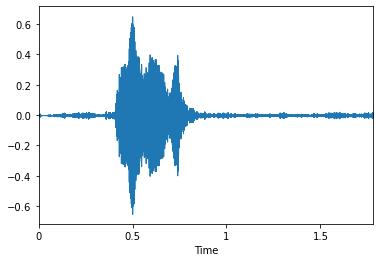

In [6]:
librosa.display.waveplot(y, sr=sr);

Let's listen to the audio. 

In [7]:
import IPython.display

IPython.display.Audio(y, rate=sr)

In automatic speech recognition, we take a waveform as input and produce a string of words corresponding to this input waveform. HMM-based speech recognition views this task as a noisy channel model. 

#### Noisy channel model 

The intuition is that we treat the acoustic waveform as a "noisy" version of the string of words, and we want to decode this noisy signal and guess the source sentence. For that, we search through a huge space of sentences and choose the one which gives us the highest probability of generating this noisy sentence. 

<img src="img/noisy_channel_model.png" width="400" height="400">

[Source](https://readyforai.com/download/speech-and-language-processing-2nd-edition-pdf)

#### Feature extraction 

As we saw before, given an acoustic waveform, we get the 1-D time series `y` when we load this waveform with a given sampling rate. Usually we do not work with this raw audio data. We **extract features** from the this data, and work with these features. The most common features in the context of speech data are [Mel-frequency cepstrum coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCCs), which represent short term power spectrum of human speech. The `y` above is divided into smaller **time frames** and MFCC features are extracted per time frame. Note that each audio file will have different number of time frames depending upon the length of the audio. Even if the same person is saying the same thing in the audio, there would be some variations. For example, if I say a short "hello", the .wav file would be shorter and we would have a small number of time frames. Whereas if I say a long heeeellloooo, the .wav file would be shorter and we would have more time frames. 

Again, we can use `librosa` for feature extraction. In particular, we will use `librosa.feature.mfcc` to extract MFCC features, which returns a numpy array of shape number of MFCC features by number of time frames. In this audio clip, with the default parameters, we have 42 frames, and 15 MFCC features are extracted for each of these frames. The rows are MFCC features and columns are time frames, and the shape of this feature matrix is $15 \times 42$ in our case. See the [documentation](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html) for more details on different parameters of `librosa.feature.mfcc` method.  

In [8]:
# extract MFC features
mfcc_feats = librosa.feature.mfcc(y, n_mfcc=15)

In [9]:
mfcc_feats.shape

(15, 70)

We can visualize the MFCC features, as shown below. We can see 15 rows and 42 columns in the plot; each column corresponds to MFCC features per time frame. For now, we won't worry about what these features actually mean. We'll assume that these are useful representations of raw audio and we'll be using them in our model. 

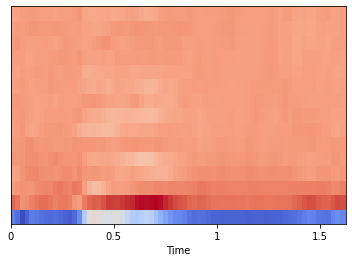

In [10]:
librosa.display.specshow(mfcc_feats, x_axis="time");

#### Phonemes or Phones 

In speech recognition, we want to break down this plot (or similar plot with speech time frames) into pieces and identify which piece corresponds to which word. It turns out that the way to think about this is not by breaking the signal down at word level but at "phoneme" level. A **phoneme** or a **phone** is a basic unit of speech sound. The word "hello" is made up of four phonemes: HH AH L OW. You can think of phonemes as units of speech which are equivalent to letters in written text. Most languages around the world on average have a total of approximately $40$ phonemes. How do you know phonemes for words in English? One of the popular pronunciation dictionaries is [The Carnegie Mellon University Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which is an open-source pronunciation dictionary for North American English. It contains over 134,000 words and their pronunciations. 

#### High level architecture of a simplistic ASR system

The picture below shows overall architecture of a simplified HMM-based speech recognizer decoding for a single sentence. An HMM-based speech recognition system usually has two components: an acoustic model and a language model. Given a waveform as input, here are the usual steps that are carried out:

- **Sampling**: Convert continuous speech into discrete time frames (i.e., sampling).
- **Feature Extraction**: Extract features for each time frame. The most common ones are Mel Frequency Cepstral Coefficient (MFCC) features. 
- **Acoustic model**: Using HMMs, identify a sequence of phonemes corresponding to the sequence of frames. One or more frames can correspond to the same phoneme. 
- **Pronunciation model**: Using these sequences and a pronunciation dictionary, create corresponding words. 
- **Language model**: Use a language model to create the most probable sequence of words. 

<img src="img/speech_recognition_architecture.png" width="600" height="600">

Note that in the architecture above, in the feature extraction component, we see the transpose of the MFCC feature matrix, where rows represent time frames and columns represent MFCC features. In this lab, we'll be working with such a matrix. Let's visualize the transpose of our "hello" MFCC matrix as a dataframe. 

In [11]:
cols = ["mfcc" + str(i + 1) for i in range(mfcc_feats.shape[0])]
index = ["frame" + str(i + 1) for i in range(mfcc_feats.shape[1])]
mfcc_df = pd.DataFrame(mfcc_feats.transpose(), columns=cols, index=index)
print("Shape of mfcc_df: ", mfcc_df.shape)
mfcc_df.head()

Shape of mfcc_df:  (70, 15)


,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15
frame1,-467.988190,102.844604,12.045694,0.002646,23.428978,16.573727,5.460759,13.721784,14.828250,3.770241,2.242991,9.936987,13.701328,10.246897,1.759200
frame2,-500.506439,80.697464,20.090965,3.930990,18.223145,18.830055,9.747242,11.718896,14.751390,6.591749,0.990790,9.004246,17.228760,11.957251,0.729018
frame3,-561.698425,30.742626,29.008072,26.402237,23.288616,20.063999,17.079750,14.578602,12.661118,11.288193,10.316488,9.555747,8.831413,8.035748,7.154084
frame4,-518.118652,42.147560,28.040850,41.797806,34.843224,34.144741,4.831817,6.388145,10.483236,7.289881,4.149110,0.329984,3.441392,16.390066,8.653028
frame5,-477.289917,59.282322,25.920567,44.421352,35.745300,34.330601,-5.092242,2.728276,4.231495,0.972606,5.456466,-0.879756,2.386652,21.880825,11.179819


#### Hidden Markov model for a word

The example below shows an HMM for the word "LOVE". The observations are MFCC vectors (acoustic features) for  time frames. The word has 3 phonemes: L, AH, and V. You can stay in a phoneme for more than one unit of time (hence the self loop). Then you transition to the next phoneme. Again, you can stay there for more than one unit of time, and then move to the next phoneme and so on.  

<img src="img/hmm_love.png" width="400" height="400">

But the problem is that these phonemes are "hidden". Our task is to convert a series of MFCC vectors into a sequence of phonemes. 

#### Our overall workflow for isolated word recognition 

Now that you have a basic idea of automatic speech recognition, let's work on a simple isolated word recognition task. In particular, you will work with a toy dataset compiled by Håkon Sandsmark. The dataset has 15 utterances (.wav files) for each of the seven fruits: apple, banana, kiwi, lime, orange, peach, pineapple. In other words, it contains total 107 .wav files, each containing a recording of one of the seven fruit names above. Each utterance is in a separate .wav file. Our goal is to build a speech recognition system for this limited vocabulary, which identifies which fruit name the person saying. 

Here is the overall approach we are going to take.  

- Split the data into train set (14 files for each fruit) and validation set (one file per fruit). 
- Read audio files. 
- Extract MFCC features. 
- Create a separate `X` for each fruit using the 14 training files for that fruit.  
- Keep track of number of frames (sequence length) in each utterance. 
- Train seven Gaussian HMMs, one for each fruit. 
- During test time, extract MFCC features for the audio file. 
- Get the likelihood of the sequence of frames using each of the seven models. 
- Pick the model label which gives the highest likelihood. 

<img src="img/isolated_words_data.png" width="600" height="600">

[Source](https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/hmm-speech-recognition/report.pdf)

Let's get started! 

<br><br>

### 2.1 Data and splitting 
rubric={accuracy:12}

Download `hmm-speech-recognition-0.1.zip` from [here](https://code.google.com/archive/p/hmm-speech-recognition/downloads), and put the unzipped data in the lab folder. We'll be reading the audio files and extracting features using the `librosa` package. 

The code below gets the labels from the data folder, loads one of the .wav files using `librosa` and plots the waveplot of the file. 

Our goal is to build separate HMM models for each fruit and test our models against the validation files. So we'll be splitting audio files into train and validation. 

Create train and validation sets such that train set has 14 audio files of per fruit and validation set has one audio file per fruit. It doesn't matter which file you decide to put in the validation set among the 15 files for each fruit. But make sure that the train and validation sets do not overlap. 

> We'll be building separate model for each fruit. 

In [12]:
data_dir = "audio/"
labels = os.listdir(data_dir)
labels

['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']

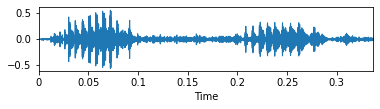

In [13]:
# Let's examine one of the audio files.
y, sr = librosa.load("audio/apple/apple01.wav")
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr);

In [14]:
y.shape

(7426,)

In [15]:
import IPython.display

IPython.display.Audio(y, rate=sr)

In [16]:
train_files={}
valid_files={}

fruits = []
labs=[]
counter = 1
for file in glob.glob("audio/**"):
    fruits.append(file)
fruits
for fruit in fruits:
    labs.append(fruit.split("/")[1])
    for lab in labs:
        look = "audio/" + lab + "/*.wav"
        files = glob.glob(look)
        valid = files.pop()
        train = files
        train_files[lab] = train
        valid_files[lab] = valid

In [17]:
train_files

{'apple': ['audio/apple/apple07.wav',
  'audio/apple/apple13.wav',
  'audio/apple/apple12.wav',
  'audio/apple/apple06.wav',
  'audio/apple/apple10.wav',
  'audio/apple/apple04.wav',
  'audio/apple/apple05.wav',
  'audio/apple/apple11.wav',
  'audio/apple/apple15.wav',
  'audio/apple/apple01.wav',
  'audio/apple/apple14.wav',
  'audio/apple/apple02.wav',
  'audio/apple/apple03.wav',
  'audio/apple/apple08.wav'],
 'kiwi': ['audio/kiwi/kiwi08.wav',
  'audio/kiwi/kiwi09.wav',
  'audio/kiwi/kiwi01.wav',
  'audio/kiwi/kiwi15.wav',
  'audio/kiwi/kiwi14.wav',
  'audio/kiwi/kiwi02.wav',
  'audio/kiwi/kiwi03.wav',
  'audio/kiwi/kiwi13.wav',
  'audio/kiwi/kiwi07.wav',
  'audio/kiwi/kiwi06.wav',
  'audio/kiwi/kiwi12.wav',
  'audio/kiwi/kiwi04.wav',
  'audio/kiwi/kiwi10.wav',
  'audio/kiwi/kiwi11.wav'],
 'lime': ['audio/lime/lime07.wav',
  'audio/lime/lime13.wav',
  'audio/lime/lime12.wav',
  'audio/lime/lime06.wav',
  'audio/lime/lime10.wav',
  'audio/lime/lime04.wav',
  'audio/lime/lime05.wav',


In [18]:
valid_files

{'apple': 'audio/apple/apple09.wav',
 'kiwi': 'audio/kiwi/kiwi05.wav',
 'lime': 'audio/lime/lime09.wav',
 'banana': 'audio/banana/banana08.wav',
 'pineapple': 'audio/pineapple/pineapple12.wav',
 'orange': 'audio/orange/orange07.wav',
 'peach': 'audio/peach/peach08.wav'}

### 2.2 Feature extraction 
The code below shows how to read an audio file, extract MFCC features, and create `X` for the fruit apple (assuming the last file in the list is in the validation set). This gives us feature vectors for each time frame in the input audio file. Note that each audio will have different number of frames and we are keeping track of the number of frames per audio in a list `seqlens`. We need these sequence lengths when we train our HMM model.  

You can create `X` and corresponding `seqlens` lists for each fruit by extracting MFCC features for each audio file for that fruit and by stacking them. 

**Your tasks:**

1. Complete the `create_X_per_fruit` function below which returns a dictionary where keys are fruit labels and values are dictionaries with two keys: `X` and `seqlens`. The value of `X` would be MFCCs for time frames and value for `seqlens` would be a list of sequence lengths. 
2. Now create `X` and `seqlens` for each of the seven fruits using the function `create_X_per_fruit`, and store it in a variable called `fruits_X_lens`. 
3. For each fruit, rows in X are going to be observations (emissions) in the HMM for that fruit. Are these observations continuous or discrete? Which of the available [HMM models from hmmlearn](https://hmmlearn.readthedocs.io/en/0.2.0/tutorial.html#available-models) would you use in this case?  

> Recall that the toy HMM example we saw in class had discrete emissions or observations (Study data science, Eat, Cry, Facebook) and so we used `hmm.MultinomialHMM`. 

In [19]:
### Example demonstrating how to create X for the fruit apple.

n_mfcc = 15
X = np.array([])
seqlens = []
# only consider the files from the train set
for sample_file in glob.glob("audio/apple/*.wav")[:14]:
    y, sr = librosa.load(sample_file)  # load the file
    mfcc_feats = librosa.feature.mfcc(y, n_mfcc=n_mfcc).T  # extract mfcc features
    seqlens.append(
        mfcc_feats.shape[0]
    )  # keep track of seqence length (# frames) in each file
    if len(X) == 0:
        X = mfcc_feats
    else:
        X = np.append(X, mfcc_feats, axis=0)
print(X.shape)

(254, 15)


What are the sequence lengths of individual audio files? 

In [20]:
pd.DataFrame(
    seqlens, index=glob.glob("audio/apple/*.wav")[:14], columns=["sequence len"]
)

,sequence len
audio/apple/apple07.wav,18
audio/apple/apple13.wav,19
audio/apple/apple12.wav,19
audio/apple/apple06.wav,16
audio/apple/apple10.wav,19
audio/apple/apple04.wav,18
audio/apple/apple05.wav,18
audio/apple/apple11.wav,19
audio/apple/apple15.wav,19
audio/apple/apple01.wav,15


<br><br>

In [21]:
def create_X_per_fruit(train_files):
    """
    Returns a dictionary containing X and seqlens for each fruit.

    Parameters:
    ----------
    train_files : dict
         train file names for each fruit

    Return:
    ----------
        dict
            dictionary where keys are fruit names and
            values are dictionaries with two keys: `X` and `seqlens`.
    """

    ### Solution_2_2_1
    ### YOUR ANSWER HERE
    result = {}
    inner_dict = {}
    for fruit in train_files.keys():
        # code adapted from example above
        n_mfcc = 15
        X = np.array([])
        seqlens = []
        # only consider the files from the train set
        for sample_file in train_files[fruit]:
            y, sr = librosa.load(sample_file)  # load the file
            mfcc_feats = librosa.feature.mfcc(y, n_mfcc=n_mfcc).T  # extract mfcc features
            seqlens.append(
                mfcc_feats.shape[0]
            )  # keep track of seqence length (# frames) in each file
            if len(X) == 0:
                X = mfcc_feats
            else:
                X = np.append(X, mfcc_feats, axis=0)
        inner_dict = {"X":X, "seqlens":seqlens}
        result[fruit] = inner_dict
    return result

In [22]:
fruits_X_lens = None

### Solution_2_2_2
### YOUR ANSWER HERE

fruits_X_lens = create_X_per_fruit(train_files)

> For each fruit, rows in X are going to be observations (emissions) in the HMM for that fruit. The observations are **continuous**. In this case, I would use either `hmm.Gaussian` or `hmm.GMMHMM`.

<br><br>

### 2.3 Classification with traditional ML classification models

Note: We are trying to solve a classification problem of identifying the class (fruit name) of the word uttered in the given audio file. We can use traditional classification ML models such as logistic regression or SVM in this case. We would need some sort of vector representing each audio file.

<br><br>

### 2.4 Training HMMs

As mentioned before, we'll be training seven HMMs, one for each fruit. 
First, we need to decide how many hidden states we should pass when building these HMMs. Recall that we roughly want each state to correspond to one phoneme. So we can make this decision based on how many phonemes are there in each fruit word. The table below shows phonemes for the seven fruits. On average we have about 4 phonemes per word. So let's try `n_components = 4` in our HMM model. 

| Fruit         | Pronunciation (phonemes) |
| ------------- |:---------|
| apple         |  AE P AH L |
| banana     |  B AH N AE N AH |
| kiwi     |  K IY W IY |
| lime     |  L AY M |
| orange     | AO R AH N JH |
| peach     |  P IY CH |
| pineapple    | P AY N AE P AH L|

For each fruit, train [`GaussianHMM`](https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GaussianHMM) with `n_components = 4` and appropriate sequence lengths,  and store the models in the `models` dict below, where keys are fruit names and values are trained models. 

In [23]:
models = defaultdict()

for fruit, data in fruits_X_lens.items():
    model = hmm.GaussianHMM(n_components=4)
    model.fit(data['X'], data['seqlens'])
    models[fruit] = model

In [24]:
pd.DataFrame(models['apple'].startprob_, columns=['Start Probabilities'])

,Start Probabilities
0,5.016426e-130
1,2.483917e-07
2,5.766467e-01
3,4.233531e-01


In [25]:
# transition matrix
pd.DataFrame(models['apple'].transmat_)

,0,1,2,3
0,8.238060e-01,1.818312e-52,0.027850,1.483438e-01
1,5.201573e-02,7.228889e-01,0.225095,1.132591e-92
2,1.943403e-01,1.943421e-01,0.611318,2.670412e-57
3,2.312859e-38,4.047813e-06,0.256788,7.432077e-01


In [26]:
trans_shape = pd.DataFrame(models['apple'].transmat_).shape
print(f"The shape of the transition matrix is {trans_shape}, corresponding to 4 n_components, for 4 hidden states.")

The shape of the transition matrix is (4, 4), corresponding to 4 n_components, for 4 hidden states.


> Note: We need to pass sequence lengths when we fit each model because each model has a different sequence lengths, depending on `X` corresponding to different audio files stacked.  When we fit each model, each audio file is an observation sequences for the model, which is based on the different audio files of different lengths. 

<br><br>

### 2.5 Visualizing HMMs

The function `visualize_hmm` below returns a dot object for the given states and fruit.  

You'll need to install the following packages in the course conda environment to run the code below. 

```
conda activate nlp
conda install -c anaconda networkx
conda install -c anaconda pydot
conda install conda install python-graphviz
```

> If you're a Windows user, you might have to try `pip install` instead of `conda install` for the packages above. 

In [27]:
import graphviz
import networkx as nx


def visualize_hmm(fruit="apple", states=["s1", "s2", "s3", "s4"]):
    transmat_df = pd.DataFrame(models[fruit].transmat_, index=states, columns=states)

    # Get edges and their weights from the transition matrix
    edges = {}
    for col in transmat_df.columns:
        for idx in transmat_df.index:
            val = round(transmat_df.loc[idx, col], 3)
            if val > 0:
                edges[(idx, col)] = val

    # Create graph
    graph = nx.MultiDiGraph()
    graph.add_nodes_from(states)  # nodes correspond to states
    print(f"Nodes:\n{graph.nodes()}\n")

    # edges represent transition probabilities
    for k, v in edges.items():
        tmp_source, tmp_dest = k[0], k[1]
        graph.add_edge(tmp_source, tmp_dest, weight=v, label=v)
    pos = nx.drawing.nx_pydot.graphviz_layout(graph, prog="dot")
    nx.draw_networkx(graph, pos)

    edge_labels = {(n1, n2): d["label"] for n1, n2, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    dot_filename = fruit + ".dot"
    nx.drawing.nx_pydot.write_dot(graph, dot_filename)
    with open(dot_filename) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

Nodes:
['s1', 's2', 's3', 's4']



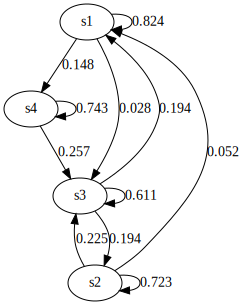

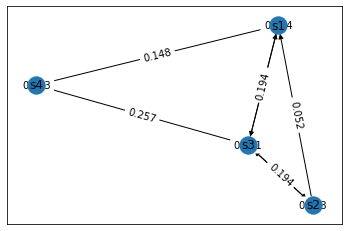

In [28]:
visualize_hmm()

Nodes:
['s1', 's2', 's3', 's4']



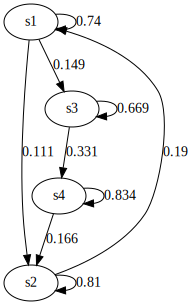

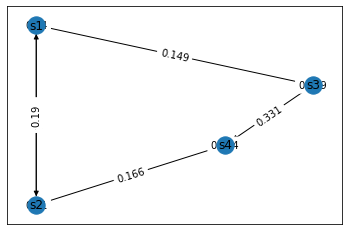

In [29]:
visualize_hmm(fruit="kiwi")

> Since it won't always be a clear mapping between phonemes and states, I would guess that the first hmm model corresponding to the word apple have the following state correspondence: [AE, P, AH, L] = [s3, s1, s4, s2]. 
> - choice of s1: s1 corresponds to the node in the model with the highest probability of transitioning to itself. I would get the phoneme "P" has a high probability of going to itself, as the model is trained on the word apple, which has 2 "P" letters. 
> - choice of s2: Similar to s1, s2 corresponds to the second highest probability of transition to itself and so, I would guess the letter "l" makes an appropriate state.
> - choice of s3: The node with the highest probability of transitioning into state s1 (phoneme P), following the 'AE' phoneme.
> - choice of s4: The last node to not guess the state correspondence.

<br><br>

### 2.6 Classification

The `predict` function below:
   - Extracts MFCC features from the `new_audio`. 
   - Scores the sequence using the `score` method of each of the seven HMMs. 
   - Returns the key of the HMM which gives the highest loglikelihood score as the label for the sequence of phonemes in the audio file. 

In [30]:
def predict(test_audio, models):
    """
    Returns the label of a given audio file using the models.

    Parameters:
    ----------
    test_audio : str
         the path of the test audio file

    models : dict
         dictionary with keys as fruit names and values as trained HMM models

    Return:
    ----------
        str : the label of the most likely fruit

    """
    y, sr = librosa.load(test_audio)  # load the file
    
    results = {} # store scores
    
    n_mfcc = 15
    mfcc_feats = librosa.feature.mfcc(y, n_mfcc=n_mfcc).T 

    for fruit, model in models.items():
        results[fruit] = model.score(mfcc_feats)
        
    return max(results, key=results.get)

In [31]:
preds={}
for fruit, valid in valid_files.items():
    pred = predict(valid, models)
    preds[fruit] = pred
preds_df = pd.DataFrame.from_dict(preds, orient='index').reset_index().rename(columns={'index':'True Label', 0:'Predicted Label'})
preds_df

,True Label,Predicted Label
0,apple,apple
1,kiwi,kiwi
2,lime,lime
3,banana,banana
4,pineapple,pineapple
5,orange,orange
6,peach,peach


In [32]:
#function to get log likelihood 

def helper(test_audio, models):

    y, sr = librosa.load(test_audio)  # load the file
    
    results = {} # store scores
    
    n_mfcc = 15
    mfcc_feats = librosa.feature.mfcc(y, n_mfcc=n_mfcc).T 

    for fruit, model in models.items():
        results[fruit] = model.score(mfcc_feats)
        results[fruit] = max(results.values())
    return results

preds={}
for fruit, valid in valid_files.items():
    pred = helper(valid, models)
    preds[fruit] = pred
logs = pd.DataFrame.from_dict(preds, orient='index')
helper_df = logs.reset_index().rename(columns={'index':'True Label', 'peach':'Highest Log Likelihood'})
helper_df=helper_df[['True Label','Highest Log Likelihood']]

In [33]:
pd.merge(preds_df, helper_df, how="inner")

,True Label,Predicted Label,Highest Log Likelihood
0,apple,apple,-1078.816199
1,kiwi,kiwi,-958.673240
2,lime,lime,-1030.739975
3,banana,banana,-1200.428437
4,pineapple,pineapple,-1472.339560
5,orange,orange,-2003.322392
6,peach,peach,-1608.677948


> The HMM model is able to classify the `new audio` perfectly. Looking at the log likelihood scores for each model, we see that for the apple model, the highest log likelihood score of -1078.81699 is associated with the label apple. The relative log likelihood score given to label apple also seemed relatively higher than the other 6 log likelihood scores. Though we are not able to tell how confident the model is, based on the log likelihoods. For the pineapple model, we see that both pineapple and apple have relatively close highest log likelihood scores, indicating that the model is able to recognize the word apple fairly well. 

<br><br>

<br><br>

### Speech recognition resources <a name="resources"></a>

- [Frank Rudzicz's slides on ASR](http://www.cs.toronto.edu/~frank/csc401/lectures/9_ASR.pdf)
- [Jurafsky and Martin 2nd edition Chapter 9](https://github.com/rain1024/slp2-pdf/blob/master/chapter-wise-pdf/%5B09%5D%20Automatic%20Speech%20Recognition.pdf)
- [Hidden Markov models for ASR](http://www1.icsi.berkeley.edu/~arlo/publications/faria_cs188_p3.pdf)
- [A tutorial on HMMs and selected applications in speech recognition](http://www.cs.toronto.edu/~frank/csc401/readings/rabiner.pdf)
- If you want to explore isolated speech recognition further, [try this dataset](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data). 